In [9]:
# wsl dass ein los gewinnt:
log05 (1/n)  > log05(89/90)
log05 (1) - log05(89/90) > log05(n)
0.5**(log05(1) - log05)  

0.10571700616122504

# Creating municipality RIDA layers

Assuming that the data we received from Septima by WeTransfer (2 folders with fgb files, plus one separate fgb file) is in the folder `data/RIDA` (from Dropbox [here](https://www.dropbox.com/scl/fo/38gkcvyfex0atdbqe3hfn/h?rlkey=z9xwq2mh6ga03c301b7f66wqx&dl=0))

This script imports each of the fgb layers we need and cuts them into muncipality-sized bites; then filters merges them to create our evaluation layers.

In [109]:
# import packages
import geopandas as gpd
import pandas as pd
import os
import matplotlib.pyplot as plt

In [143]:
# read in kommuner data and make subfolders
muni = gpd.read_file("data/raw/municipalities/muni_boundary.gpkg")

In [3]:
# create subfolders for each municipality
for _, row in muni.iterrows():
    os.makedirs(f"data/raw/RIDA/{row.kommunekode}", exist_ok=True)

In [9]:
# dictionary: key is fgb file name (origin file), value is gpkg file name (destination file)
rida_dict = {
    "facilit_indkoeb.fgb": "indkoeb.gpkg",
    "facilit_overnatning.fgb": "overnatning.gpkg",
    "facilit_rasteplads.fgb": "rasteplads.gpkg",
    'facilit_service.fgb': "infoservice.gpkg",
    'land_anvendelse.fgb': "anvendelse.gpkg", # new! formerly 5 layers (byomrade, dyrket areal, naturareal, skovinddeling, teknisk areal)
    'land_beskyttnatur_flade.fgb': "beskyttet_natur.gpkg",
    'land_beskyttnatur_linje.fgb': "beskyttet_vandloeb.gpkg",
    'land_besoegs.fgb': "besoeg.gpkg",
    "land_fortid.fgb": "fortidsminder.gpkg",
    'land_frednatpark.fgb': "frednatpark.gpkg", # new!
    'land_landemaerke.fgb': "landemaerker.gpkg",
    'land_udflugt.fgb': "udflugt.gpkg",
    'land_vaerdifuld.fgb': "vaerdifuld.gpkg", # new!
    'facilit_overnatning.fgb': "overnatning.gpkg",    
}


In [10]:
%%time
# read in fgb file; 
# for each of the kommuner, clip fgb file to its extent; 
# then save in corresponding folder
for k, v in rida_dict.items():
    print(f"reading {k}")
    gdf = gpd.read_file(f"data/RIDA/{k}")
    assert gdf.crs == muni.crs
    for _, row in muni.iterrows():
        gdf_curr = gdf.copy()
        gdf_curr = gdf_curr.clip(row.geometry)
        gdf_curr = gdf_curr.reset_index(drop=True)
        if not gdf_curr.empty:
            gdf_curr.to_file(f"data/raw/RIDA/{row.kommunekode}/{v}")    

reading land_beskyttnatur_linje.fgb
reading land_besoegs.fgb
reading land_fortid.fgb
reading land_frednatpark.fgb
reading land_landemaerke.fgb
reading land_udflugt.fgb
reading land_vaerdifuld.fgb
reading facilit_overnatning.fgb
CPU times: user 7min 30s, sys: 15.2 s, total: 7min 45s
Wall time: 7min 53s


In [ ]:
def merge_gdfs(gdf_list):
    # make sure all gdfs are the same crs
    assert len(set([gdf.crs for gdf in gdf_list])) == 1
    # make sure we have the same geometries everywhere
    assert len(set([t for gdf in gdf_list for t in gdf.type])) == 1
    # concatenate with pandas
    gdf_main = pd.concat([gdf[["gruppe", "type", "geometry"]].copy() for gdf in gdf_list])
    gdf_main = gdf_main.reset_index(drop=True)
    return gdf_main

In [171]:
"0161", "0240", "0163", "0411" # no besoeg
"0269", "0159" # no overnatning
"0183", "0147", "0190", "0187", "0825" # no fortidsminder
"0157", "0175" # no udflugt
list(muni.kommunekode).index("0411")

96

In [177]:
munis_remove = [
    "0161", "0240", "0163", "0411", # no besoeg
    "0269", "0159", # no overnatning
    "0183", "0147", "0190", "0187", "0825", # no fortidsminder
    "0157", "0175" # no udflugt
]


munis = list(muni.kommunekode)
for m in munis_remove:
    munis.remove(m)

start kode 0779
	 data read in
	 0779 done
start kode 0390
	 data read in
	 0390 done


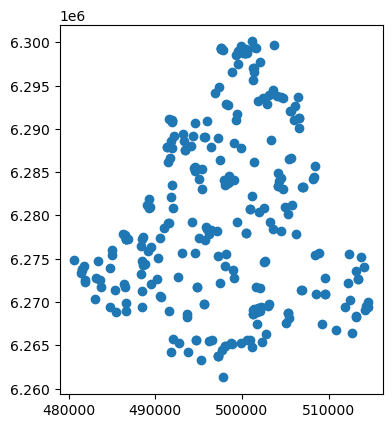

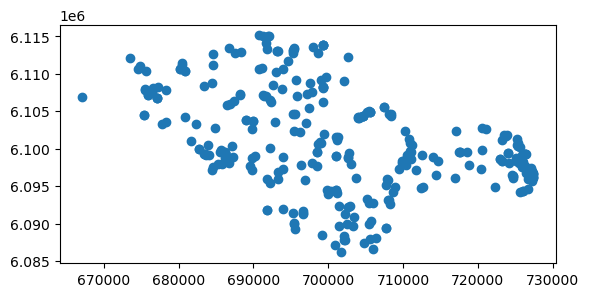

In [172]:
# evaluation layers:
# read in all fgb-to-gpkg layers;
# drop not needed columns;
# explode;
# drop not needed geometries;
# filter and merge;
# save in corresponding kommune subfolder
 
for kode in munis:
    
    print(f"start kode {kode}")

    anve = gpd.read_file(f"data/raw/RIDA/{kode}/anvendelse.gpkg")
    anve = anve[["gruppe", "type", "geometry"]]
    anve = anve.explode(index_parts=False)
    anve = anve[anve.geometry.type == "Polygon"].copy().reset_index(drop=True)

    besk = gpd.read_file(f"data/raw/RIDA/{kode}/beskyttet_natur.gpkg")
    besk = besk[["type", "geometry"]]
    besk["gruppe"] = "beskyttet_natur"
    besk = besk.explode(index_parts=False)
    besk = besk[besk.geometry.type == "Polygon"].copy().reset_index(drop=True)

    beso = gpd.read_file(f"data/raw/RIDA/{kode}/besoeg.gpkg")
    beso = beso[["gruppe", "type", "geometry"]]
    beso = beso.explode(index_parts=False)
    beso = beso[beso.geometry.type == "Point"].copy().reset_index(drop=True)

    fort = gpd.read_file(f"data/raw/RIDA/{kode}/fortidsminder.gpkg")
    fort = fort[["gruppe", "type", "geometry"]]
    fort = fort.explode(index_parts=False)
    fort = fort[fort.geometry.type == "Point"].copy().reset_index(drop=True)

    fred = gpd.read_file(f"data/raw/RIDA/{kode}/frednatpark.gpkg")
    fred = fred[["type", "geometry"]]
    fred["gruppe"] = "frednatpark"
    fred = fred.explode(index_parts=False)
    fred = fred[fred.geometry.type == "Polygon"].copy().reset_index(drop=True)

    indk = gpd.read_file(f"data/raw/RIDA/{kode}/indkoeb.gpkg")
    indk = indk[["type", "geometry"]]
    indk["gruppe"] = "indkoeb"
    indk = indk.explode(index_parts=False)
    indk = indk[indk.geometry.type == "Point"].copy().reset_index(drop=True)

    info = gpd.read_file(f"data/raw/RIDA/{kode}/infoservice.gpkg")
    info = info[["gruppe", "type", "geometry"]]
    info = info.explode(index_parts=False)
    info = info[info.geometry.type == "Point"].copy().reset_index(drop=True)

    land = gpd.read_file(f"data/raw/RIDA/{kode}/landemaerker.gpkg")
    land = land[["type", "geometry"]]
    land["gruppe"] = "landemaerker"
    land = land.explode(index_parts=False)
    land = land[land.geometry.type == "Point"].copy().reset_index(drop=True)

    over = gpd.read_file(f"data/raw/RIDA/{kode}/overnatning.gpkg")
    over = over[["type", "geometry"]]
    over["gruppe"] = "overnatning"
    over = over.explode(index_parts=False)
    over = over[over.geometry.type == "Point"].copy().reset_index(drop=True)

    rast = gpd.read_file(f"data/raw/RIDA/{kode}/rasteplads.gpkg")
    rast = rast[["gruppe", "type", "geometry"]]
    rast = rast.explode(index_parts=False)
    rast = rast[rast.geometry.type == "Point"].copy().reset_index(drop=True)

    udfl = gpd.read_file(f"data/raw/RIDA/{kode}/udflugt.gpkg")
    udfl = udfl[["gruppe", "type", "geometry"]]
    udfl = udfl.explode(index_parts=False)
    udfl = udfl[udfl.geometry.type == "Point"].copy().reset_index(drop=True)

    vaer = gpd.read_file(f"data/raw/RIDA/{kode}/vaerdifuld.gpkg")
    vaer = vaer[["type", "geometry"]]
    vaer["gruppe"] = "vaerdifuld"
    vaer = vaer.explode(index_parts=False)
    vaer = vaer[vaer.geometry.type == "Polygon"].copy().reset_index(drop=True)

    print("\t data read in")

    nature = merge_gdfs(
        [
            anve[(anve["gruppe"]=="Naturtyper") & -anve["type"].isin(["Råstofområde"])].copy(),
            anve[anve["gruppe"]=="Skovinddeling"].copy(),
            besk.copy(),
            vaer[vaer["type"]=="Naturbeskyttelsesområde"].copy(),
            fred.copy()
        ]
    )

    if len(nature) > 0:
        nature.to_file(f"data/raw/RIDA/{kode}/nature.gpkg", index = False)
    
        
    culture = merge_gdfs(
        [
            anve[anve["type"].isin(['Bykerne'])].copy(),
            vaer[vaer["type"].isin(
                [
                    'Kulturhistorisk bevaringsværdi', 
                    'Værdifuldt kulturmiljø', 
                    'Bevaringsværdig landskab'
                ]
            )].copy()
        ]
    )

    if len(culture) > 0:
        culture.to_file(
            f"data/raw/RIDA/{kode}/culture.gpkg", 
            index = False)
        
    sommerhus = anve[
        anve["type"].isin(
            ['Sommerhusområde', 'Sommerhusområde skov']
            )
        ].copy().reset_index(drop=True)
    if len(sommerhus) > 0:
        sommerhus.to_file(
            f"data/raw/RIDA/{kode}/sommerhus.gpkg", 
            index = False)

    agri = anve[
        anve["gruppe"]=="Dyrkede arealer"].copy().reset_index(
            drop=True)

    if len(agri) > 0:
        agri.to_file(
            f"data/raw/RIDA/{kode}/agriculture.gpkg", 
            index = False)
        
    bad = merge_gdfs(
        [
            anve[(anve["gruppe"]=="Teknisk areal") & (-anve["type"].isin(["Sportsanlæg"]))].copy(),
            anve[(anve["gruppe"]=="Bymæssig anvendelse") & (anve["type"].isin(["Høj bebyggelse", "Erhverv"]))].copy()
        ]
    )

    if len(bad) > 0:
        bad.to_file(
            f"data/raw/RIDA/{kode}/bad.gpkg", 
            index = False)
        

    pois = merge_gdfs(
        [beso, fort, udfl, land]
    )

    if len(pois) > 0:
        pois.to_file(
            f"data/raw/RIDA/{kode}/pois.gpkg", 
            index = False)
        
    faci = merge_gdfs(
        [
            info[-info["type"].isin(["Turistkontor"])].copy(),
            rast,
            indk
        ]
    )

    if len(faci) > 0:
        faci.to_file(
            f"data/raw/RIDA/{kode}/facilities.gpkg", 
            index = False)
        
    service = merge_gdfs(
        [indk, over, info[info["type"].isin(["Turistkontor"])]]
    )

    if len(service) > 0:
        service.to_file(
            f"data/raw/RIDA/{kode}/service.gpkg", 
            index = False)
        
    print(f"\t {kode} done")

* ~~0269: no over~~
* ~~"0183", "0147", "0190", "0825": no fortidsminder~~
* ~~"0157", "0175": no udflugt~~
* ~~0161, 0163: no besoeg, no fortidsminder~~
* ~~0240: no besoeg, no overnatning~~
* ~~0411: no besoeg, no indkoeb, no vaerdifuld, no bad (!)~~
* ~~0187: no fortidsminder, no overnatning~~
* 0159: no over, no udflugt

In [195]:
# SPECIAL CASES: NO OVERNATNING

for kode in ["0269"]:
    
    print(f"start kode {kode}")

    anve = gpd.read_file(f"data/raw/RIDA/{kode}/anvendelse.gpkg")
    anve = anve[["gruppe", "type", "geometry"]]
    anve = anve.explode(index_parts=False)
    anve = anve[anve.geometry.type == "Polygon"].copy().reset_index(drop=True)

    besk = gpd.read_file(f"data/raw/RIDA/{kode}/beskyttet_natur.gpkg")
    besk = besk[["type", "geometry"]]
    besk["gruppe"] = "beskyttet_natur"
    besk = besk.explode(index_parts=False)
    besk = besk[besk.geometry.type == "Polygon"].copy().reset_index(drop=True)

    beso = gpd.read_file(f"data/raw/RIDA/{kode}/besoeg.gpkg")
    beso = beso[["gruppe", "type", "geometry"]]
    beso = beso.explode(index_parts=False)
    beso = beso[beso.geometry.type == "Point"].copy().reset_index(drop=True)

    fort = gpd.read_file(f"data/raw/RIDA/{kode}/fortidsminder.gpkg")
    fort = fort[["gruppe", "type", "geometry"]]
    fort = fort.explode(index_parts=False)
    fort = fort[fort.geometry.type == "Point"].copy().reset_index(drop=True)

    fred = gpd.read_file(f"data/raw/RIDA/{kode}/frednatpark.gpkg")
    fred = fred[["type", "geometry"]]
    fred["gruppe"] = "frednatpark"
    fred = fred.explode(index_parts=False)
    fred = fred[fred.geometry.type == "Polygon"].copy().reset_index(drop=True)

    indk = gpd.read_file(f"data/raw/RIDA/{kode}/indkoeb.gpkg")
    indk = indk[["type", "geometry"]]
    indk["gruppe"] = "indkoeb"
    indk = indk.explode(index_parts=False)
    indk = indk[indk.geometry.type == "Point"].copy().reset_index(drop=True)

    info = gpd.read_file(f"data/raw/RIDA/{kode}/infoservice.gpkg")
    info = info[["gruppe", "type", "geometry"]]
    info = info.explode(index_parts=False)
    info = info[info.geometry.type == "Point"].copy().reset_index(drop=True)

    land = gpd.read_file(f"data/raw/RIDA/{kode}/landemaerker.gpkg")
    land = land[["type", "geometry"]]
    land["gruppe"] = "landemaerker"
    land = land.explode(index_parts=False)
    land = land[land.geometry.type == "Point"].copy().reset_index(drop=True)

    # over = gpd.read_file(f"data/raw/RIDA/{kode}/overnatning.gpkg")
    # over = over[["type", "geometry"]]
    # over["gruppe"] = "overnatning"
    # over = over.explode(index_parts=False)
    # over = over[over.geometry.type == "Point"].copy().reset_index(drop=True)

    rast = gpd.read_file(f"data/raw/RIDA/{kode}/rasteplads.gpkg")
    rast = rast[["gruppe", "type", "geometry"]]
    rast = rast.explode(index_parts=False)
    rast = rast[rast.geometry.type == "Point"].copy().reset_index(drop=True)

    udfl = gpd.read_file(f"data/raw/RIDA/{kode}/udflugt.gpkg")
    udfl = udfl[["gruppe", "type", "geometry"]]
    udfl = udfl.explode(index_parts=False)
    udfl = udfl[udfl.geometry.type == "Point"].copy().reset_index(drop=True)

    vaer = gpd.read_file(f"data/raw/RIDA/{kode}/vaerdifuld.gpkg")
    vaer = vaer[["type", "geometry"]]
    vaer["gruppe"] = "vaerdifuld"
    vaer = vaer.explode(index_parts=False)
    vaer = vaer[vaer.geometry.type == "Polygon"].copy().reset_index(drop=True)

    print("\t data read in")

    nature = merge_gdfs(
        [
            anve[(anve["gruppe"]=="Naturtyper") & -anve["type"].isin(["Råstofområde"])].copy(),
            anve[anve["gruppe"]=="Skovinddeling"].copy(),
            besk.copy(),
            vaer[vaer["type"]=="Naturbeskyttelsesområde"].copy(),
            fred.copy()
        ]
    )

    if len(nature) > 0:
        nature.to_file(f"data/raw/RIDA/{kode}/nature.gpkg", index = False)
    
        
    culture = merge_gdfs(
        [
            anve[anve["type"].isin(['Bykerne'])].copy(),
            vaer[vaer["type"].isin(
                [
                    'Kulturhistorisk bevaringsværdi', 
                    'Værdifuldt kulturmiljø', 
                    'Bevaringsværdig landskab'
                ]
            )].copy()
        ]
    )

    if len(culture) > 0:
        culture.to_file(
            f"data/raw/RIDA/{kode}/culture.gpkg", 
            index = False)
        
    sommerhus = anve[
        anve["type"].isin(
            ['Sommerhusområde', 'Sommerhusområde skov']
            )
        ].copy().reset_index(drop=True)
    if len(sommerhus) > 0:
        sommerhus.to_file(
            f"data/raw/RIDA/{kode}/sommerhus.gpkg", 
            index = False)

    agri = anve[
        anve["gruppe"]=="Dyrkede arealer"].copy().reset_index(
            drop=True)

    if len(agri) > 0:
        agri.to_file(
            f"data/raw/RIDA/{kode}/agriculture.gpkg", 
            index = False)
        
    bad = merge_gdfs(
        [
            anve[(anve["gruppe"]=="Teknisk areal") & (-anve["type"].isin(["Sportsanlæg"]))].copy(),
            anve[(anve["gruppe"]=="Bymæssig anvendelse") & (anve["type"].isin(["Høj bebyggelse", "Erhverv"]))].copy()
        ]
    )

    if len(bad) > 0:
        bad.to_file(
            f"data/raw/RIDA/{kode}/bad.gpkg", 
            index = False)
        

    pois = merge_gdfs(
        [beso, fort, udfl, land]
    )

    if len(pois) > 0:
        pois.to_file(
            f"data/raw/RIDA/{kode}/pois.gpkg", 
            index = False)
        
    faci = merge_gdfs(
        [
            info[-info["type"].isin(["Turistkontor"])].copy(),
            rast,
            indk
        ]
    )

    if len(faci) > 0:
        faci.to_file(
            f"data/raw/RIDA/{kode}/facilities.gpkg", 
            index = False)
        
    service = merge_gdfs(
        [
            indk, 
            #over, 
            info[info["type"].isin(["Turistkontor"])]]
    )

    if len(service) > 0:
        service.to_file(
            f"data/raw/RIDA/{kode}/service.gpkg", 
            index = False)
        
    print(f"\t {kode} done")

start kode 0269
	 data read in
	 0269 done


In [196]:
# SPECIAL CASES: NO FORTIDSMINDER

for kode in ["0183", "0147", "0190", "0825"]:
    
    print(f"start kode {kode}")

    anve = gpd.read_file(f"data/raw/RIDA/{kode}/anvendelse.gpkg")
    anve = anve[["gruppe", "type", "geometry"]]
    anve = anve.explode(index_parts=False)
    anve = anve[anve.geometry.type == "Polygon"].copy().reset_index(drop=True)

    besk = gpd.read_file(f"data/raw/RIDA/{kode}/beskyttet_natur.gpkg")
    besk = besk[["type", "geometry"]]
    besk["gruppe"] = "beskyttet_natur"
    besk = besk.explode(index_parts=False)
    besk = besk[besk.geometry.type == "Polygon"].copy().reset_index(drop=True)

    beso = gpd.read_file(f"data/raw/RIDA/{kode}/besoeg.gpkg")
    beso = beso[["gruppe", "type", "geometry"]]
    beso = beso.explode(index_parts=False)
    beso = beso[beso.geometry.type == "Point"].copy().reset_index(drop=True)

    # fort = gpd.read_file(f"data/raw/RIDA/{kode}/fortidsminder.gpkg")
    # fort = fort[["gruppe", "type", "geometry"]]
    # fort = fort.explode(index_parts=False)
    # fort = fort[fort.geometry.type == "Point"].copy().reset_index(drop=True)

    fred = gpd.read_file(f"data/raw/RIDA/{kode}/frednatpark.gpkg")
    fred = fred[["type", "geometry"]]
    fred["gruppe"] = "frednatpark"
    fred = fred.explode(index_parts=False)
    fred = fred[fred.geometry.type == "Polygon"].copy().reset_index(drop=True)

    indk = gpd.read_file(f"data/raw/RIDA/{kode}/indkoeb.gpkg")
    indk = indk[["type", "geometry"]]
    indk["gruppe"] = "indkoeb"
    indk = indk.explode(index_parts=False)
    indk = indk[indk.geometry.type == "Point"].copy().reset_index(drop=True)

    info = gpd.read_file(f"data/raw/RIDA/{kode}/infoservice.gpkg")
    info = info[["gruppe", "type", "geometry"]]
    info = info.explode(index_parts=False)
    info = info[info.geometry.type == "Point"].copy().reset_index(drop=True)

    land = gpd.read_file(f"data/raw/RIDA/{kode}/landemaerker.gpkg")
    land = land[["type", "geometry"]]
    land["gruppe"] = "landemaerker"
    land = land.explode(index_parts=False)
    land = land[land.geometry.type == "Point"].copy().reset_index(drop=True)

    over = gpd.read_file(f"data/raw/RIDA/{kode}/overnatning.gpkg")
    over = over[["type", "geometry"]]
    over["gruppe"] = "overnatning"
    over = over.explode(index_parts=False)
    over = over[over.geometry.type == "Point"].copy().reset_index(drop=True)

    rast = gpd.read_file(f"data/raw/RIDA/{kode}/rasteplads.gpkg")
    rast = rast[["gruppe", "type", "geometry"]]
    rast = rast.explode(index_parts=False)
    rast = rast[rast.geometry.type == "Point"].copy().reset_index(drop=True)

    udfl = gpd.read_file(f"data/raw/RIDA/{kode}/udflugt.gpkg")
    udfl = udfl[["gruppe", "type", "geometry"]]
    udfl = udfl.explode(index_parts=False)
    udfl = udfl[udfl.geometry.type == "Point"].copy().reset_index(drop=True)

    vaer = gpd.read_file(f"data/raw/RIDA/{kode}/vaerdifuld.gpkg")
    vaer = vaer[["type", "geometry"]]
    vaer["gruppe"] = "vaerdifuld"
    vaer = vaer.explode(index_parts=False)
    vaer = vaer[vaer.geometry.type == "Polygon"].copy().reset_index(drop=True)

    print("\t data read in")

    nature = merge_gdfs(
        [
            anve[(anve["gruppe"]=="Naturtyper") & -anve["type"].isin(["Råstofområde"])].copy(),
            anve[anve["gruppe"]=="Skovinddeling"].copy(),
            besk.copy(),
            vaer[vaer["type"]=="Naturbeskyttelsesområde"].copy(),
            fred.copy()
        ]
    )

    if len(nature) > 0:
        nature.to_file(f"data/raw/RIDA/{kode}/nature.gpkg", index = False)
    
        
    culture = merge_gdfs(
        [
            anve[anve["type"].isin(['Bykerne'])].copy(),
            vaer[vaer["type"].isin(
                [
                    'Kulturhistorisk bevaringsværdi', 
                    'Værdifuldt kulturmiljø', 
                    'Bevaringsværdig landskab'
                ]
            )].copy()
        ]
    )

    if len(culture) > 0:
        culture.to_file(
            f"data/raw/RIDA/{kode}/culture.gpkg", 
            index = False)
        
    sommerhus = anve[
        anve["type"].isin(
            ['Sommerhusområde', 'Sommerhusområde skov']
            )
        ].copy().reset_index(drop=True)
    if len(sommerhus) > 0:
        sommerhus.to_file(
            f"data/raw/RIDA/{kode}/sommerhus.gpkg", 
            index = False)

    agri = anve[
        anve["gruppe"]=="Dyrkede arealer"].copy().reset_index(
            drop=True)

    if len(agri) > 0:
        agri.to_file(
            f"data/raw/RIDA/{kode}/agriculture.gpkg", 
            index = False)
        
    bad = merge_gdfs(
        [
            anve[(anve["gruppe"]=="Teknisk areal") & (-anve["type"].isin(["Sportsanlæg"]))].copy(),
            anve[(anve["gruppe"]=="Bymæssig anvendelse") & (anve["type"].isin(["Høj bebyggelse", "Erhverv"]))].copy()
        ]
    )

    if len(bad) > 0:
        bad.to_file(
            f"data/raw/RIDA/{kode}/bad.gpkg", 
            index = False)
        

    pois = merge_gdfs(
        [
            beso, 
            #fort, 
            udfl, 
            land]
    )

    if len(pois) > 0:
        pois.to_file(
            f"data/raw/RIDA/{kode}/pois.gpkg", 
            index = False)
        
    faci = merge_gdfs(
        [
            info[-info["type"].isin(["Turistkontor"])].copy(),
            rast,
            indk
        ]
    )

    if len(faci) > 0:
        faci.to_file(
            f"data/raw/RIDA/{kode}/facilities.gpkg", 
            index = False)
        
    service = merge_gdfs(
        [indk, over, info[info["type"].isin(["Turistkontor"])]]
    )

    if len(service) > 0:
        service.to_file(
            f"data/raw/RIDA/{kode}/service.gpkg", 
            index = False)
        
    print(f"\t {kode} done")

start kode 0183
	 data read in
	 0183 done
start kode 0147
	 data read in
	 0147 done
start kode 0190
	 data read in
	 0190 done
start kode 0825
	 data read in
	 0825 done


In [197]:
# SPECIAL CASES: NO UDFLUGT

for kode in ["0157", "0175"]:
    
    print(f"start kode {kode}")

    anve = gpd.read_file(f"data/raw/RIDA/{kode}/anvendelse.gpkg")
    anve = anve[["gruppe", "type", "geometry"]]
    anve = anve.explode(index_parts=False)
    anve = anve[anve.geometry.type == "Polygon"].copy().reset_index(drop=True)

    besk = gpd.read_file(f"data/raw/RIDA/{kode}/beskyttet_natur.gpkg")
    besk = besk[["type", "geometry"]]
    besk["gruppe"] = "beskyttet_natur"
    besk = besk.explode(index_parts=False)
    besk = besk[besk.geometry.type == "Polygon"].copy().reset_index(drop=True)

    beso = gpd.read_file(f"data/raw/RIDA/{kode}/besoeg.gpkg")
    beso = beso[["gruppe", "type", "geometry"]]
    beso = beso.explode(index_parts=False)
    beso = beso[beso.geometry.type == "Point"].copy().reset_index(drop=True)

    fort = gpd.read_file(f"data/raw/RIDA/{kode}/fortidsminder.gpkg")
    fort = fort[["gruppe", "type", "geometry"]]
    fort = fort.explode(index_parts=False)
    fort = fort[fort.geometry.type == "Point"].copy().reset_index(drop=True)

    fred = gpd.read_file(f"data/raw/RIDA/{kode}/frednatpark.gpkg")
    fred = fred[["type", "geometry"]]
    fred["gruppe"] = "frednatpark"
    fred = fred.explode(index_parts=False)
    fred = fred[fred.geometry.type == "Polygon"].copy().reset_index(drop=True)

    indk = gpd.read_file(f"data/raw/RIDA/{kode}/indkoeb.gpkg")
    indk = indk[["type", "geometry"]]
    indk["gruppe"] = "indkoeb"
    indk = indk.explode(index_parts=False)
    indk = indk[indk.geometry.type == "Point"].copy().reset_index(drop=True)

    info = gpd.read_file(f"data/raw/RIDA/{kode}/infoservice.gpkg")
    info = info[["gruppe", "type", "geometry"]]
    info = info.explode(index_parts=False)
    info = info[info.geometry.type == "Point"].copy().reset_index(drop=True)

    land = gpd.read_file(f"data/raw/RIDA/{kode}/landemaerker.gpkg")
    land = land[["type", "geometry"]]
    land["gruppe"] = "landemaerker"
    land = land.explode(index_parts=False)
    land = land[land.geometry.type == "Point"].copy().reset_index(drop=True)

    over = gpd.read_file(f"data/raw/RIDA/{kode}/overnatning.gpkg")
    over = over[["type", "geometry"]]
    over["gruppe"] = "overnatning"
    over = over.explode(index_parts=False)
    over = over[over.geometry.type == "Point"].copy().reset_index(drop=True)

    rast = gpd.read_file(f"data/raw/RIDA/{kode}/rasteplads.gpkg")
    rast = rast[["gruppe", "type", "geometry"]]
    rast = rast.explode(index_parts=False)
    rast = rast[rast.geometry.type == "Point"].copy().reset_index(drop=True)

    # udfl = gpd.read_file(f"data/raw/RIDA/{kode}/udflugt.gpkg")
    # udfl = udfl[["gruppe", "type", "geometry"]]
    # udfl = udfl.explode(index_parts=False)
    # udfl = udfl[udfl.geometry.type == "Point"].copy().reset_index(drop=True)

    vaer = gpd.read_file(f"data/raw/RIDA/{kode}/vaerdifuld.gpkg")
    vaer = vaer[["type", "geometry"]]
    vaer["gruppe"] = "vaerdifuld"
    vaer = vaer.explode(index_parts=False)
    vaer = vaer[vaer.geometry.type == "Polygon"].copy().reset_index(drop=True)

    print("\t data read in")

    nature = merge_gdfs(
        [
            anve[(anve["gruppe"]=="Naturtyper") & -anve["type"].isin(["Råstofområde"])].copy(),
            anve[anve["gruppe"]=="Skovinddeling"].copy(),
            besk.copy(),
            vaer[vaer["type"]=="Naturbeskyttelsesområde"].copy(),
            fred.copy()
        ]
    )

    if len(nature) > 0:
        nature.to_file(f"data/raw/RIDA/{kode}/nature.gpkg", index = False)
    
        
    culture = merge_gdfs(
        [
            anve[anve["type"].isin(['Bykerne'])].copy(),
            vaer[vaer["type"].isin(
                [
                    'Kulturhistorisk bevaringsværdi', 
                    'Værdifuldt kulturmiljø', 
                    'Bevaringsværdig landskab'
                ]
            )].copy()
        ]
    )

    if len(culture) > 0:
        culture.to_file(
            f"data/raw/RIDA/{kode}/culture.gpkg", 
            index = False)
        
    sommerhus = anve[
        anve["type"].isin(
            ['Sommerhusområde', 'Sommerhusområde skov']
            )
        ].copy().reset_index(drop=True)
    if len(sommerhus) > 0:
        sommerhus.to_file(
            f"data/raw/RIDA/{kode}/sommerhus.gpkg", 
            index = False)

    agri = anve[
        anve["gruppe"]=="Dyrkede arealer"].copy().reset_index(
            drop=True)

    if len(agri) > 0:
        agri.to_file(
            f"data/raw/RIDA/{kode}/agriculture.gpkg", 
            index = False)
        
    bad = merge_gdfs(
        [
            anve[(anve["gruppe"]=="Teknisk areal") & (-anve["type"].isin(["Sportsanlæg"]))].copy(),
            anve[(anve["gruppe"]=="Bymæssig anvendelse") & (anve["type"].isin(["Høj bebyggelse", "Erhverv"]))].copy()
        ]
    )

    if len(bad) > 0:
        bad.to_file(
            f"data/raw/RIDA/{kode}/bad.gpkg", 
            index = False)
        

    pois = merge_gdfs(
        [
            beso, 
            fort, 
            # udfl, 
            land
        ]
    )

    if len(pois) > 0:
        pois.to_file(
            f"data/raw/RIDA/{kode}/pois.gpkg", 
            index = False)
        
    faci = merge_gdfs(
        [
            info[-info["type"].isin(["Turistkontor"])].copy(),
            rast,
            indk
        ]
    )

    if len(faci) > 0:
        faci.to_file(
            f"data/raw/RIDA/{kode}/facilities.gpkg", 
            index = False)
        
    service = merge_gdfs(
        [indk, over, info[info["type"].isin(["Turistkontor"])]]
    )

    if len(service) > 0:
        service.to_file(
            f"data/raw/RIDA/{kode}/service.gpkg", 
            index = False)
        
    print(f"\t {kode} done")

start kode 0157
	 data read in
	 0157 done
start kode 0175
	 data read in
	 0175 done


In [198]:
# SPECIAL CASES: NO BESOEG, NO FORTIDSMINDER

for kode in ["0161", "0163"]:
    
    print(f"start kode {kode}")

    anve = gpd.read_file(f"data/raw/RIDA/{kode}/anvendelse.gpkg")
    anve = anve[["gruppe", "type", "geometry"]]
    anve = anve.explode(index_parts=False)
    anve = anve[anve.geometry.type == "Polygon"].copy().reset_index(drop=True)

    besk = gpd.read_file(f"data/raw/RIDA/{kode}/beskyttet_natur.gpkg")
    besk = besk[["type", "geometry"]]
    besk["gruppe"] = "beskyttet_natur"
    besk = besk.explode(index_parts=False)
    besk = besk[besk.geometry.type == "Polygon"].copy().reset_index(drop=True)

    # beso = gpd.read_file(f"data/raw/RIDA/{kode}/besoeg.gpkg")
    # beso = beso[["gruppe", "type", "geometry"]]
    # beso = beso.explode(index_parts=False)
    # beso = beso[beso.geometry.type == "Point"].copy().reset_index(drop=True)

    # fort = gpd.read_file(f"data/raw/RIDA/{kode}/fortidsminder.gpkg")
    # fort = fort[["gruppe", "type", "geometry"]]
    # fort = fort.explode(index_parts=False)
    # fort = fort[fort.geometry.type == "Point"].copy().reset_index(drop=True)

    fred = gpd.read_file(f"data/raw/RIDA/{kode}/frednatpark.gpkg")
    fred = fred[["type", "geometry"]]
    fred["gruppe"] = "frednatpark"
    fred = fred.explode(index_parts=False)
    fred = fred[fred.geometry.type == "Polygon"].copy().reset_index(drop=True)

    indk = gpd.read_file(f"data/raw/RIDA/{kode}/indkoeb.gpkg")
    indk = indk[["type", "geometry"]]
    indk["gruppe"] = "indkoeb"
    indk = indk.explode(index_parts=False)
    indk = indk[indk.geometry.type == "Point"].copy().reset_index(drop=True)

    info = gpd.read_file(f"data/raw/RIDA/{kode}/infoservice.gpkg")
    info = info[["gruppe", "type", "geometry"]]
    info = info.explode(index_parts=False)
    info = info[info.geometry.type == "Point"].copy().reset_index(drop=True)

    land = gpd.read_file(f"data/raw/RIDA/{kode}/landemaerker.gpkg")
    land = land[["type", "geometry"]]
    land["gruppe"] = "landemaerker"
    land = land.explode(index_parts=False)
    land = land[land.geometry.type == "Point"].copy().reset_index(drop=True)

    over = gpd.read_file(f"data/raw/RIDA/{kode}/overnatning.gpkg")
    over = over[["type", "geometry"]]
    over["gruppe"] = "overnatning"
    over = over.explode(index_parts=False)
    over = over[over.geometry.type == "Point"].copy().reset_index(drop=True)

    rast = gpd.read_file(f"data/raw/RIDA/{kode}/rasteplads.gpkg")
    rast = rast[["gruppe", "type", "geometry"]]
    rast = rast.explode(index_parts=False)
    rast = rast[rast.geometry.type == "Point"].copy().reset_index(drop=True)

    udfl = gpd.read_file(f"data/raw/RIDA/{kode}/udflugt.gpkg")
    udfl = udfl[["gruppe", "type", "geometry"]]
    udfl = udfl.explode(index_parts=False)
    udfl = udfl[udfl.geometry.type == "Point"].copy().reset_index(drop=True)

    vaer = gpd.read_file(f"data/raw/RIDA/{kode}/vaerdifuld.gpkg")
    vaer = vaer[["type", "geometry"]]
    vaer["gruppe"] = "vaerdifuld"
    vaer = vaer.explode(index_parts=False)
    vaer = vaer[vaer.geometry.type == "Polygon"].copy().reset_index(drop=True)

    print("\t data read in")

    nature = merge_gdfs(
        [
            anve[(anve["gruppe"]=="Naturtyper") & -anve["type"].isin(["Råstofområde"])].copy(),
            anve[anve["gruppe"]=="Skovinddeling"].copy(),
            besk.copy(),
            vaer[vaer["type"]=="Naturbeskyttelsesområde"].copy(),
            fred.copy()
        ]
    )

    if len(nature) > 0:
        nature.to_file(f"data/raw/RIDA/{kode}/nature.gpkg", index = False)
    
        
    culture = merge_gdfs(
        [
            anve[anve["type"].isin(['Bykerne'])].copy(),
            vaer[vaer["type"].isin(
                [
                    'Kulturhistorisk bevaringsværdi', 
                    'Værdifuldt kulturmiljø', 
                    'Bevaringsværdig landskab'
                ]
            )].copy()
        ]
    )

    if len(culture) > 0:
        culture.to_file(
            f"data/raw/RIDA/{kode}/culture.gpkg", 
            index = False)
        
    sommerhus = anve[
        anve["type"].isin(
            ['Sommerhusområde', 'Sommerhusområde skov']
            )
        ].copy().reset_index(drop=True)
    if len(sommerhus) > 0:
        sommerhus.to_file(
            f"data/raw/RIDA/{kode}/sommerhus.gpkg", 
            index = False)

    agri = anve[
        anve["gruppe"]=="Dyrkede arealer"].copy().reset_index(
            drop=True)

    if len(agri) > 0:
        agri.to_file(
            f"data/raw/RIDA/{kode}/agriculture.gpkg", 
            index = False)
        
    bad = merge_gdfs(
        [
            anve[(anve["gruppe"]=="Teknisk areal") & (-anve["type"].isin(["Sportsanlæg"]))].copy(),
            anve[(anve["gruppe"]=="Bymæssig anvendelse") & (anve["type"].isin(["Høj bebyggelse", "Erhverv"]))].copy()
        ]
    )

    if len(bad) > 0:
        bad.to_file(
            f"data/raw/RIDA/{kode}/bad.gpkg", 
            index = False)
        

    pois = merge_gdfs(
        [
            # beso, 
            # fort, 
            udfl, 
            land
        ]
    )

    if len(pois) > 0:
        pois.to_file(
            f"data/raw/RIDA/{kode}/pois.gpkg", 
            index = False)
        
    faci = merge_gdfs(
        [
            info[-info["type"].isin(["Turistkontor"])].copy(),
            rast,
            indk
        ]
    )

    if len(faci) > 0:
        faci.to_file(
            f"data/raw/RIDA/{kode}/facilities.gpkg", 
            index = False)
        
    service = merge_gdfs(
        [indk, over, info[info["type"].isin(["Turistkontor"])]]
    )

    if len(service) > 0:
        service.to_file(
            f"data/raw/RIDA/{kode}/service.gpkg", 
            index = False)
        
    print(f"\t {kode} done")

start kode 0161
	 data read in
	 0161 done
start kode 0163
	 data read in
	 0163 done


In [199]:
# SPECIAL CASES: 0240: no besoeg, no overnatning

for kode in ["0240"]:
    
    print(f"start kode {kode}")

    anve = gpd.read_file(f"data/raw/RIDA/{kode}/anvendelse.gpkg")
    anve = anve[["gruppe", "type", "geometry"]]
    anve = anve.explode(index_parts=False)
    anve = anve[anve.geometry.type == "Polygon"].copy().reset_index(drop=True)

    besk = gpd.read_file(f"data/raw/RIDA/{kode}/beskyttet_natur.gpkg")
    besk = besk[["type", "geometry"]]
    besk["gruppe"] = "beskyttet_natur"
    besk = besk.explode(index_parts=False)
    besk = besk[besk.geometry.type == "Polygon"].copy().reset_index(drop=True)

    # beso = gpd.read_file(f"data/raw/RIDA/{kode}/besoeg.gpkg")
    # beso = beso[["gruppe", "type", "geometry"]]
    # beso = beso.explode(index_parts=False)
    # beso = beso[beso.geometry.type == "Point"].copy().reset_index(drop=True)

    fort = gpd.read_file(f"data/raw/RIDA/{kode}/fortidsminder.gpkg")
    fort = fort[["gruppe", "type", "geometry"]]
    fort = fort.explode(index_parts=False)
    fort = fort[fort.geometry.type == "Point"].copy().reset_index(drop=True)

    fred = gpd.read_file(f"data/raw/RIDA/{kode}/frednatpark.gpkg")
    fred = fred[["type", "geometry"]]
    fred["gruppe"] = "frednatpark"
    fred = fred.explode(index_parts=False)
    fred = fred[fred.geometry.type == "Polygon"].copy().reset_index(drop=True)

    indk = gpd.read_file(f"data/raw/RIDA/{kode}/indkoeb.gpkg")
    indk = indk[["type", "geometry"]]
    indk["gruppe"] = "indkoeb"
    indk = indk.explode(index_parts=False)
    indk = indk[indk.geometry.type == "Point"].copy().reset_index(drop=True)

    info = gpd.read_file(f"data/raw/RIDA/{kode}/infoservice.gpkg")
    info = info[["gruppe", "type", "geometry"]]
    info = info.explode(index_parts=False)
    info = info[info.geometry.type == "Point"].copy().reset_index(drop=True)

    land = gpd.read_file(f"data/raw/RIDA/{kode}/landemaerker.gpkg")
    land = land[["type", "geometry"]]
    land["gruppe"] = "landemaerker"
    land = land.explode(index_parts=False)
    land = land[land.geometry.type == "Point"].copy().reset_index(drop=True)

    # over = gpd.read_file(f"data/raw/RIDA/{kode}/overnatning.gpkg")
    # over = over[["type", "geometry"]]
    # over["gruppe"] = "overnatning"
    # over = over.explode(index_parts=False)
    # over = over[over.geometry.type == "Point"].copy().reset_index(drop=True)

    rast = gpd.read_file(f"data/raw/RIDA/{kode}/rasteplads.gpkg")
    rast = rast[["gruppe", "type", "geometry"]]
    rast = rast.explode(index_parts=False)
    rast = rast[rast.geometry.type == "Point"].copy().reset_index(drop=True)

    udfl = gpd.read_file(f"data/raw/RIDA/{kode}/udflugt.gpkg")
    udfl = udfl[["gruppe", "type", "geometry"]]
    udfl = udfl.explode(index_parts=False)
    udfl = udfl[udfl.geometry.type == "Point"].copy().reset_index(drop=True)

    vaer = gpd.read_file(f"data/raw/RIDA/{kode}/vaerdifuld.gpkg")
    vaer = vaer[["type", "geometry"]]
    vaer["gruppe"] = "vaerdifuld"
    vaer = vaer.explode(index_parts=False)
    vaer = vaer[vaer.geometry.type == "Polygon"].copy().reset_index(drop=True)

    print("\t data read in")

    nature = merge_gdfs(
        [
            anve[(anve["gruppe"]=="Naturtyper") & -anve["type"].isin(["Råstofområde"])].copy(),
            anve[anve["gruppe"]=="Skovinddeling"].copy(),
            besk.copy(),
            vaer[vaer["type"]=="Naturbeskyttelsesområde"].copy(),
            fred.copy()
        ]
    )

    if len(nature) > 0:
        nature.to_file(f"data/raw/RIDA/{kode}/nature.gpkg", index = False)
    
        
    culture = merge_gdfs(
        [
            anve[anve["type"].isin(['Bykerne'])].copy(),
            vaer[vaer["type"].isin(
                [
                    'Kulturhistorisk bevaringsværdi', 
                    'Værdifuldt kulturmiljø', 
                    'Bevaringsværdig landskab'
                ]
            )].copy()
        ]
    )

    if len(culture) > 0:
        culture.to_file(
            f"data/raw/RIDA/{kode}/culture.gpkg", 
            index = False)
        
    sommerhus = anve[
        anve["type"].isin(
            ['Sommerhusområde', 'Sommerhusområde skov']
            )
        ].copy().reset_index(drop=True)
    if len(sommerhus) > 0:
        sommerhus.to_file(
            f"data/raw/RIDA/{kode}/sommerhus.gpkg", 
            index = False)

    agri = anve[
        anve["gruppe"]=="Dyrkede arealer"].copy().reset_index(
            drop=True)

    if len(agri) > 0:
        agri.to_file(
            f"data/raw/RIDA/{kode}/agriculture.gpkg", 
            index = False)
        
    bad = merge_gdfs(
        [
            anve[(anve["gruppe"]=="Teknisk areal") & (-anve["type"].isin(["Sportsanlæg"]))].copy(),
            anve[(anve["gruppe"]=="Bymæssig anvendelse") & (anve["type"].isin(["Høj bebyggelse", "Erhverv"]))].copy()
        ]
    )

    if len(bad) > 0:
        bad.to_file(
            f"data/raw/RIDA/{kode}/bad.gpkg", 
            index = False)
        

    pois = merge_gdfs(
        [
            # beso, 
            fort, 
            udfl, 
            land
        ]
    )

    if len(pois) > 0:
        pois.to_file(
            f"data/raw/RIDA/{kode}/pois.gpkg", 
            index = False)
        
    faci = merge_gdfs(
        [
            info[-info["type"].isin(["Turistkontor"])].copy(),
            rast,
            indk
        ]
    )

    if len(faci) > 0:
        faci.to_file(
            f"data/raw/RIDA/{kode}/facilities.gpkg", 
            index = False)
        
    service = merge_gdfs(
        [
            indk, 
            # over, 
            info[info["type"].isin(["Turistkontor"])]]
    )

    if len(service) > 0:
        service.to_file(
            f"data/raw/RIDA/{kode}/service.gpkg", 
            index = False)
        
    print(f"\t {kode} done")

start kode 0240
	 data read in
	 0240 done


In [205]:
# SPECIAL CASES: 0411: no besoeg, no indkoeb, no vaerdifuld

for kode in ["0411"]:
    
    print(f"start kode {kode}")

    anve = gpd.read_file(f"data/raw/RIDA/{kode}/anvendelse.gpkg")
    anve = anve[["gruppe", "type", "geometry"]]
    anve = anve.explode(index_parts=False)
    anve = anve[anve.geometry.type == "Polygon"].copy().reset_index(drop=True)

    besk = gpd.read_file(f"data/raw/RIDA/{kode}/beskyttet_natur.gpkg")
    besk = besk[["type", "geometry"]]
    besk["gruppe"] = "beskyttet_natur"
    besk = besk.explode(index_parts=False)
    besk = besk[besk.geometry.type == "Polygon"].copy().reset_index(drop=True)

    # beso = gpd.read_file(f"data/raw/RIDA/{kode}/besoeg.gpkg")
    # beso = beso[["gruppe", "type", "geometry"]]
    # beso = beso.explode(index_parts=False)
    # beso = beso[beso.geometry.type == "Point"].copy().reset_index(drop=True)

    fort = gpd.read_file(f"data/raw/RIDA/{kode}/fortidsminder.gpkg")
    fort = fort[["gruppe", "type", "geometry"]]
    fort = fort.explode(index_parts=False)
    fort = fort[fort.geometry.type == "Point"].copy().reset_index(drop=True)

    fred = gpd.read_file(f"data/raw/RIDA/{kode}/frednatpark.gpkg")
    fred = fred[["type", "geometry"]]
    fred["gruppe"] = "frednatpark"
    fred = fred.explode(index_parts=False)
    fred = fred[fred.geometry.type == "Polygon"].copy().reset_index(drop=True)

    # indk = gpd.read_file(f"data/raw/RIDA/{kode}/indkoeb.gpkg")
    # indk = indk[["type", "geometry"]]
    # indk["gruppe"] = "indkoeb"
    # indk = indk.explode(index_parts=False)
    # indk = indk[indk.geometry.type == "Point"].copy().reset_index(drop=True)

    info = gpd.read_file(f"data/raw/RIDA/{kode}/infoservice.gpkg")
    info = info[["gruppe", "type", "geometry"]]
    info = info.explode(index_parts=False)
    info = info[info.geometry.type == "Point"].copy().reset_index(drop=True)

    land = gpd.read_file(f"data/raw/RIDA/{kode}/landemaerker.gpkg")
    land = land[["type", "geometry"]]
    land["gruppe"] = "landemaerker"
    land = land.explode(index_parts=False)
    land = land[land.geometry.type == "Point"].copy().reset_index(drop=True)

    over = gpd.read_file(f"data/raw/RIDA/{kode}/overnatning.gpkg")
    over = over[["type", "geometry"]]
    over["gruppe"] = "overnatning"
    over = over.explode(index_parts=False)
    over = over[over.geometry.type == "Point"].copy().reset_index(drop=True)

    rast = gpd.read_file(f"data/raw/RIDA/{kode}/rasteplads.gpkg")
    rast = rast[["gruppe", "type", "geometry"]]
    rast = rast.explode(index_parts=False)
    rast = rast[rast.geometry.type == "Point"].copy().reset_index(drop=True)

    udfl = gpd.read_file(f"data/raw/RIDA/{kode}/udflugt.gpkg")
    udfl = udfl[["gruppe", "type", "geometry"]]
    udfl = udfl.explode(index_parts=False)
    udfl = udfl[udfl.geometry.type == "Point"].copy().reset_index(drop=True)

    # vaer = gpd.read_file(f"data/raw/RIDA/{kode}/vaerdifuld.gpkg")
    # vaer = vaer[["type", "geometry"]]
    # vaer["gruppe"] = "vaerdifuld"
    # vaer = vaer.explode(index_parts=False)
    # vaer = vaer[vaer.geometry.type == "Polygon"].copy().reset_index(drop=True)

    print("\t data read in")

    nature = merge_gdfs(
        [
            anve[(anve["gruppe"]=="Naturtyper") & -anve["type"].isin(["Råstofområde"])].copy(),
            anve[anve["gruppe"]=="Skovinddeling"].copy(),
            besk.copy(),
            # vaer[vaer["type"]=="Naturbeskyttelsesområde"].copy(),
            fred.copy()
        ]
    )

    if len(nature) > 0:
        nature.to_file(f"data/raw/RIDA/{kode}/nature.gpkg", index = False)
    
        
    culture = anve[anve["type"].isin(['Bykerne'])].copy().reset_index(drop=True)

    if len(culture) > 0:
        culture.to_file(
            f"data/raw/RIDA/{kode}/culture.gpkg", 
            index = False)
        
    sommerhus = anve[
        anve["type"].isin(
            ['Sommerhusområde', 'Sommerhusområde skov']
            )
        ].copy().reset_index(drop=True)
    if len(sommerhus) > 0:
        sommerhus.to_file(
            f"data/raw/RIDA/{kode}/sommerhus.gpkg", 
            index = False)

    agri = anve[
        anve["gruppe"]=="Dyrkede arealer"].copy().reset_index(
            drop=True)

    if len(agri) > 0:
        agri.to_file(
            f"data/raw/RIDA/{kode}/agriculture.gpkg", 
            index = False)
        
    # bad = merge_gdfs(
    #     [
    #         anve[(anve["gruppe"]=="Teknisk areal") & (-anve["type"].isin(["Sportsanlæg"]))].copy(),
    #         anve[(anve["gruppe"]=="Bymæssig anvendelse") & (anve["type"].isin(["Høj bebyggelse", "Erhverv"]))].copy()
    #     ]
    # )

    # if len(bad) > 0:
    #     bad.to_file(
    #         f"data/raw/RIDA/{kode}/bad.gpkg", 
    #         index = False)
        

    pois = merge_gdfs(
        [
            # beso, 
            fort, 
            udfl, 
            land
        ]
    )

    if len(pois) > 0:
        pois.to_file(
            f"data/raw/RIDA/{kode}/pois.gpkg", 
            index = False)
        
    faci = merge_gdfs(
        [
            info[-info["type"].isin(["Turistkontor"])].copy(),
            rast,
            # indk
        ]
    )

    if len(faci) > 0:
        faci.to_file(
            f"data/raw/RIDA/{kode}/facilities.gpkg", 
            index = False)
        
    service = merge_gdfs(
        [indk, over, info[info["type"].isin(["Turistkontor"])]]
    )

    if len(service) > 0:
        service.to_file(
            f"data/raw/RIDA/{kode}/service.gpkg", 
            index = False)
        
    print(f"\t {kode} done")

start kode 0411
	 data read in
	 0411 done


In [206]:
# SPECIAL CASES: 0187: no fortidsminder, no overnatning

for kode in ["0187"]:
    
    print(f"start kode {kode}")

    anve = gpd.read_file(f"data/raw/RIDA/{kode}/anvendelse.gpkg")
    anve = anve[["gruppe", "type", "geometry"]]
    anve = anve.explode(index_parts=False)
    anve = anve[anve.geometry.type == "Polygon"].copy().reset_index(drop=True)

    besk = gpd.read_file(f"data/raw/RIDA/{kode}/beskyttet_natur.gpkg")
    besk = besk[["type", "geometry"]]
    besk["gruppe"] = "beskyttet_natur"
    besk = besk.explode(index_parts=False)
    besk = besk[besk.geometry.type == "Polygon"].copy().reset_index(drop=True)

    beso = gpd.read_file(f"data/raw/RIDA/{kode}/besoeg.gpkg")
    beso = beso[["gruppe", "type", "geometry"]]
    beso = beso.explode(index_parts=False)
    beso = beso[beso.geometry.type == "Point"].copy().reset_index(drop=True)

    # fort = gpd.read_file(f"data/raw/RIDA/{kode}/fortidsminder.gpkg")
    # fort = fort[["gruppe", "type", "geometry"]]
    # fort = fort.explode(index_parts=False)
    # fort = fort[fort.geometry.type == "Point"].copy().reset_index(drop=True)

    fred = gpd.read_file(f"data/raw/RIDA/{kode}/frednatpark.gpkg")
    fred = fred[["type", "geometry"]]
    fred["gruppe"] = "frednatpark"
    fred = fred.explode(index_parts=False)
    fred = fred[fred.geometry.type == "Polygon"].copy().reset_index(drop=True)

    indk = gpd.read_file(f"data/raw/RIDA/{kode}/indkoeb.gpkg")
    indk = indk[["type", "geometry"]]
    indk["gruppe"] = "indkoeb"
    indk = indk.explode(index_parts=False)
    indk = indk[indk.geometry.type == "Point"].copy().reset_index(drop=True)

    info = gpd.read_file(f"data/raw/RIDA/{kode}/infoservice.gpkg")
    info = info[["gruppe", "type", "geometry"]]
    info = info.explode(index_parts=False)
    info = info[info.geometry.type == "Point"].copy().reset_index(drop=True)

    land = gpd.read_file(f"data/raw/RIDA/{kode}/landemaerker.gpkg")
    land = land[["type", "geometry"]]
    land["gruppe"] = "landemaerker"
    land = land.explode(index_parts=False)
    land = land[land.geometry.type == "Point"].copy().reset_index(drop=True)

    # over = gpd.read_file(f"data/raw/RIDA/{kode}/overnatning.gpkg")
    # over = over[["type", "geometry"]]
    # over["gruppe"] = "overnatning"
    # over = over.explode(index_parts=False)
    # over = over[over.geometry.type == "Point"].copy().reset_index(drop=True)

    rast = gpd.read_file(f"data/raw/RIDA/{kode}/rasteplads.gpkg")
    rast = rast[["gruppe", "type", "geometry"]]
    rast = rast.explode(index_parts=False)
    rast = rast[rast.geometry.type == "Point"].copy().reset_index(drop=True)

    udfl = gpd.read_file(f"data/raw/RIDA/{kode}/udflugt.gpkg")
    udfl = udfl[["gruppe", "type", "geometry"]]
    udfl = udfl.explode(index_parts=False)
    udfl = udfl[udfl.geometry.type == "Point"].copy().reset_index(drop=True)

    vaer = gpd.read_file(f"data/raw/RIDA/{kode}/vaerdifuld.gpkg")
    vaer = vaer[["type", "geometry"]]
    vaer["gruppe"] = "vaerdifuld"
    vaer = vaer.explode(index_parts=False)
    vaer = vaer[vaer.geometry.type == "Polygon"].copy().reset_index(drop=True)

    print("\t data read in")

    nature = merge_gdfs(
        [
            anve[(anve["gruppe"]=="Naturtyper") & -anve["type"].isin(["Råstofområde"])].copy(),
            anve[anve["gruppe"]=="Skovinddeling"].copy(),
            besk.copy(),
            vaer[vaer["type"]=="Naturbeskyttelsesområde"].copy(),
            fred.copy()
        ]
    )

    if len(nature) > 0:
        nature.to_file(f"data/raw/RIDA/{kode}/nature.gpkg", index = False)
    
        
    culture = merge_gdfs(
        [
            anve[anve["type"].isin(['Bykerne'])].copy(),
            vaer[vaer["type"].isin(
                [
                    'Kulturhistorisk bevaringsværdi', 
                    'Værdifuldt kulturmiljø', 
                    'Bevaringsværdig landskab'
                ]
            )].copy()
        ]
    )

    if len(culture) > 0:
        culture.to_file(
            f"data/raw/RIDA/{kode}/culture.gpkg", 
            index = False)
        
    sommerhus = anve[
        anve["type"].isin(
            ['Sommerhusområde', 'Sommerhusområde skov']
            )
        ].copy().reset_index(drop=True)
    if len(sommerhus) > 0:
        sommerhus.to_file(
            f"data/raw/RIDA/{kode}/sommerhus.gpkg", 
            index = False)

    agri = anve[
        anve["gruppe"]=="Dyrkede arealer"].copy().reset_index(
            drop=True)

    if len(agri) > 0:
        agri.to_file(
            f"data/raw/RIDA/{kode}/agriculture.gpkg", 
            index = False)
        
    bad = merge_gdfs(
        [
            anve[(anve["gruppe"]=="Teknisk areal") & (-anve["type"].isin(["Sportsanlæg"]))].copy(),
            anve[(anve["gruppe"]=="Bymæssig anvendelse") & (anve["type"].isin(["Høj bebyggelse", "Erhverv"]))].copy()
        ]
    )

    if len(bad) > 0:
        bad.to_file(
            f"data/raw/RIDA/{kode}/bad.gpkg", 
            index = False)
        

    pois = merge_gdfs(
        [
            beso, 
            # fort, 
            udfl, 
            land]
    )

    if len(pois) > 0:
        pois.to_file(
            f"data/raw/RIDA/{kode}/pois.gpkg", 
            index = False)
        
    faci = merge_gdfs(
        [
            info[-info["type"].isin(["Turistkontor"])].copy(),
            rast,
            indk
        ]
    )

    if len(faci) > 0:
        faci.to_file(
            f"data/raw/RIDA/{kode}/facilities.gpkg", 
            index = False)
        
    service = merge_gdfs(
        [
            indk, 
            # over, 
            info[info["type"].isin(["Turistkontor"])]]
    )

    if len(service) > 0:
        service.to_file(
            f"data/raw/RIDA/{kode}/service.gpkg", 
            index = False)
        
    print(f"\t {kode} done")

start kode 0187
	 data read in
	 0187 done


In [207]:
# SPECIAL CASES: 0159: no over, no udflugt

for kode in ["0159"]:
    
    print(f"start kode {kode}")

    anve = gpd.read_file(f"data/raw/RIDA/{kode}/anvendelse.gpkg")
    anve = anve[["gruppe", "type", "geometry"]]
    anve = anve.explode(index_parts=False)
    anve = anve[anve.geometry.type == "Polygon"].copy().reset_index(drop=True)

    besk = gpd.read_file(f"data/raw/RIDA/{kode}/beskyttet_natur.gpkg")
    besk = besk[["type", "geometry"]]
    besk["gruppe"] = "beskyttet_natur"
    besk = besk.explode(index_parts=False)
    besk = besk[besk.geometry.type == "Polygon"].copy().reset_index(drop=True)

    beso = gpd.read_file(f"data/raw/RIDA/{kode}/besoeg.gpkg")
    beso = beso[["gruppe", "type", "geometry"]]
    beso = beso.explode(index_parts=False)
    beso = beso[beso.geometry.type == "Point"].copy().reset_index(drop=True)

    fort = gpd.read_file(f"data/raw/RIDA/{kode}/fortidsminder.gpkg")
    fort = fort[["gruppe", "type", "geometry"]]
    fort = fort.explode(index_parts=False)
    fort = fort[fort.geometry.type == "Point"].copy().reset_index(drop=True)

    fred = gpd.read_file(f"data/raw/RIDA/{kode}/frednatpark.gpkg")
    fred = fred[["type", "geometry"]]
    fred["gruppe"] = "frednatpark"
    fred = fred.explode(index_parts=False)
    fred = fred[fred.geometry.type == "Polygon"].copy().reset_index(drop=True)

    indk = gpd.read_file(f"data/raw/RIDA/{kode}/indkoeb.gpkg")
    indk = indk[["type", "geometry"]]
    indk["gruppe"] = "indkoeb"
    indk = indk.explode(index_parts=False)
    indk = indk[indk.geometry.type == "Point"].copy().reset_index(drop=True)

    info = gpd.read_file(f"data/raw/RIDA/{kode}/infoservice.gpkg")
    info = info[["gruppe", "type", "geometry"]]
    info = info.explode(index_parts=False)
    info = info[info.geometry.type == "Point"].copy().reset_index(drop=True)

    land = gpd.read_file(f"data/raw/RIDA/{kode}/landemaerker.gpkg")
    land = land[["type", "geometry"]]
    land["gruppe"] = "landemaerker"
    land = land.explode(index_parts=False)
    land = land[land.geometry.type == "Point"].copy().reset_index(drop=True)

    # over = gpd.read_file(f"data/raw/RIDA/{kode}/overnatning.gpkg")
    # over = over[["type", "geometry"]]
    # over["gruppe"] = "overnatning"
    # over = over.explode(index_parts=False)
    # over = over[over.geometry.type == "Point"].copy().reset_index(drop=True)

    rast = gpd.read_file(f"data/raw/RIDA/{kode}/rasteplads.gpkg")
    rast = rast[["gruppe", "type", "geometry"]]
    rast = rast.explode(index_parts=False)
    rast = rast[rast.geometry.type == "Point"].copy().reset_index(drop=True)

    # udfl = gpd.read_file(f"data/raw/RIDA/{kode}/udflugt.gpkg")
    # udfl = udfl[["gruppe", "type", "geometry"]]
    # udfl = udfl.explode(index_parts=False)
    # udfl = udfl[udfl.geometry.type == "Point"].copy().reset_index(drop=True)

    vaer = gpd.read_file(f"data/raw/RIDA/{kode}/vaerdifuld.gpkg")
    vaer = vaer[["type", "geometry"]]
    vaer["gruppe"] = "vaerdifuld"
    vaer = vaer.explode(index_parts=False)
    vaer = vaer[vaer.geometry.type == "Polygon"].copy().reset_index(drop=True)

    print("\t data read in")

    nature = merge_gdfs(
        [
            anve[(anve["gruppe"]=="Naturtyper") & -anve["type"].isin(["Råstofområde"])].copy(),
            anve[anve["gruppe"]=="Skovinddeling"].copy(),
            besk.copy(),
            vaer[vaer["type"]=="Naturbeskyttelsesområde"].copy(),
            fred.copy()
        ]
    )

    if len(nature) > 0:
        nature.to_file(f"data/raw/RIDA/{kode}/nature.gpkg", index = False)
    
        
    culture = merge_gdfs(
        [
            anve[anve["type"].isin(['Bykerne'])].copy(),
            vaer[vaer["type"].isin(
                [
                    'Kulturhistorisk bevaringsværdi', 
                    'Værdifuldt kulturmiljø', 
                    'Bevaringsværdig landskab'
                ]
            )].copy()
        ]
    )

    if len(culture) > 0:
        culture.to_file(
            f"data/raw/RIDA/{kode}/culture.gpkg", 
            index = False)
        
    sommerhus = anve[
        anve["type"].isin(
            ['Sommerhusområde', 'Sommerhusområde skov']
            )
        ].copy().reset_index(drop=True)
    if len(sommerhus) > 0:
        sommerhus.to_file(
            f"data/raw/RIDA/{kode}/sommerhus.gpkg", 
            index = False)

    agri = anve[
        anve["gruppe"]=="Dyrkede arealer"].copy().reset_index(
            drop=True)

    if len(agri) > 0:
        agri.to_file(
            f"data/raw/RIDA/{kode}/agriculture.gpkg", 
            index = False)
        
    bad = merge_gdfs(
        [
            anve[(anve["gruppe"]=="Teknisk areal") & (-anve["type"].isin(["Sportsanlæg"]))].copy(),
            anve[(anve["gruppe"]=="Bymæssig anvendelse") & (anve["type"].isin(["Høj bebyggelse", "Erhverv"]))].copy()
        ]
    )

    if len(bad) > 0:
        bad.to_file(
            f"data/raw/RIDA/{kode}/bad.gpkg", 
            index = False)
        

    pois = merge_gdfs(
        [
            beso, 
            fort, 
            # udfl, 
            land
        ]
    )

    if len(pois) > 0:
        pois.to_file(
            f"data/raw/RIDA/{kode}/pois.gpkg", 
            index = False)
        
    faci = merge_gdfs(
        [
            info[-info["type"].isin(["Turistkontor"])].copy(),
            rast,
            indk
        ]
    )

    if len(faci) > 0:
        faci.to_file(
            f"data/raw/RIDA/{kode}/facilities.gpkg", 
            index = False)
        
    service = merge_gdfs(
        [
            indk, 
            #over, 
            info[info["type"].isin(["Turistkontor"])]]
    )

    if len(service) > 0:
        service.to_file(
            f"data/raw/RIDA/{kode}/service.gpkg", 
            index = False)
        
    print(f"\t {kode} done")

start kode 0159
	 data read in
	 0159 done
